<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ результатов</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Блок самоконтроля.
Схема работы с сетом:

- Качество данных на входе: оценить аномалии, пропуски и тд
- Генерация новых полезных признаков (features engineering)
- Оптимизация подбора гиперпараметров
- Изменение типов данных признаков для ускорения вычислений.
- Анализ остатков (разницы между прогнозом и фактом): выявить, в каких случаях чаще всего ошибается, а в каких выдает наиболее точный результат

## Подготовка

In [1]:
!pip install optuna

In [2]:
# Импортируем необходимые инструменты

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb

import optuna
import time

STATE = 12345

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv',
                       index_col=[0], # список номеров столбцов или названий столбцов
                       parse_dates=[0])
except:
    data = pd.read_csv(r'C:\Users\Вадим и Света\Downloads\taxi.csv',
                       index_col=[0], # список номеров столбцов или названий столбцов
                       parse_dates=[0])
    
print('Временной ряд данных расположен последовательно:', data.index.is_monotonic)
data.shape[0]/(6*24)

Временной ряд данных расположен последовательно: True


184.0

## Анализ

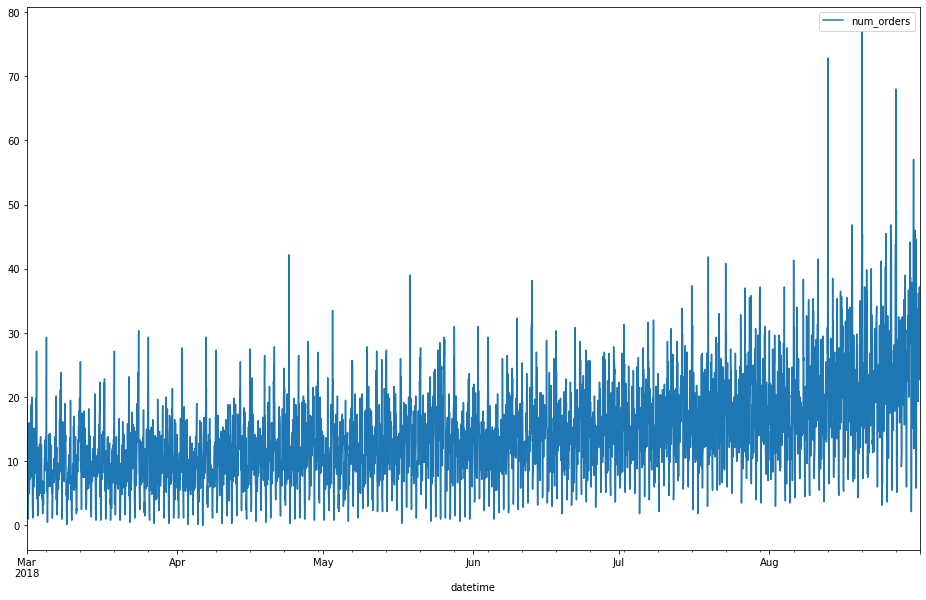

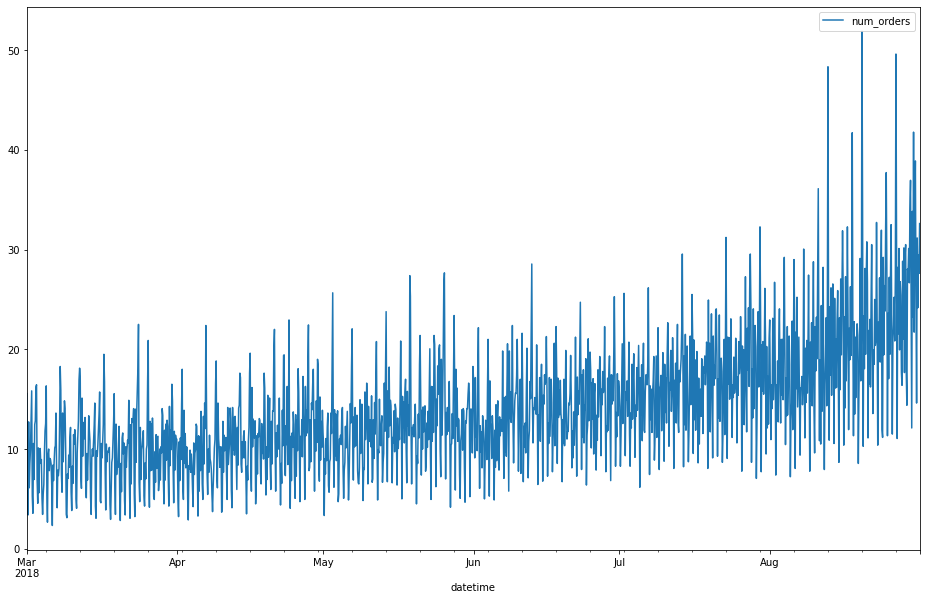

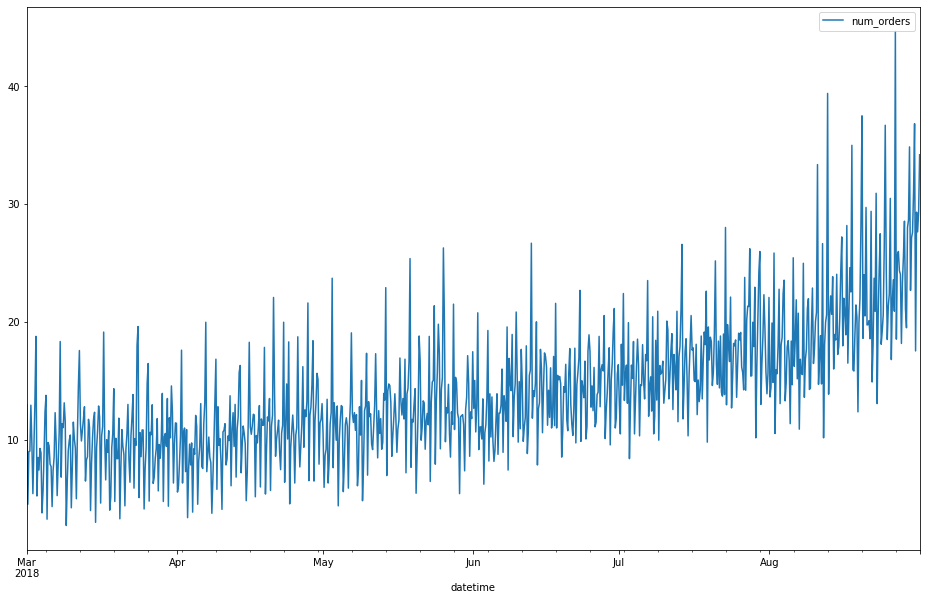

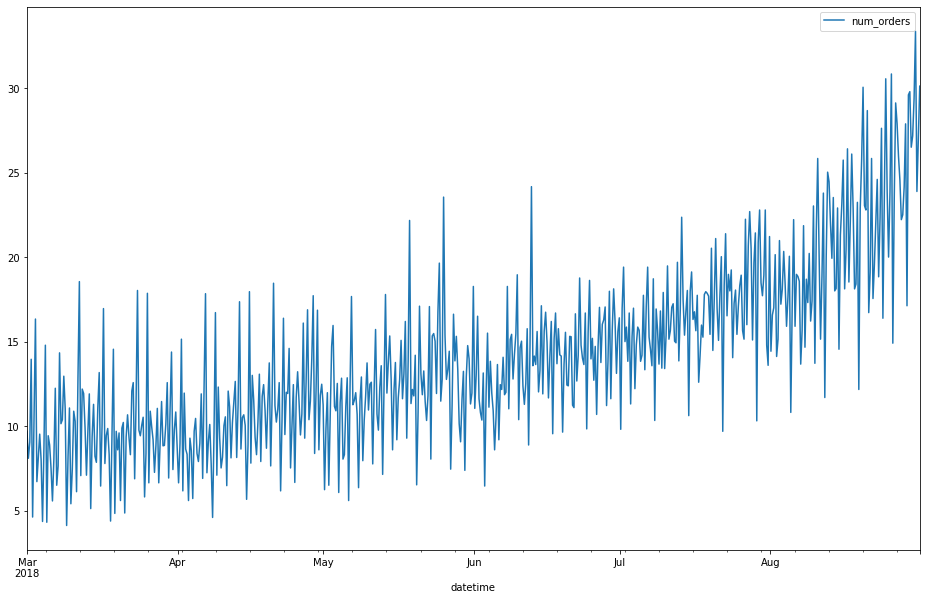

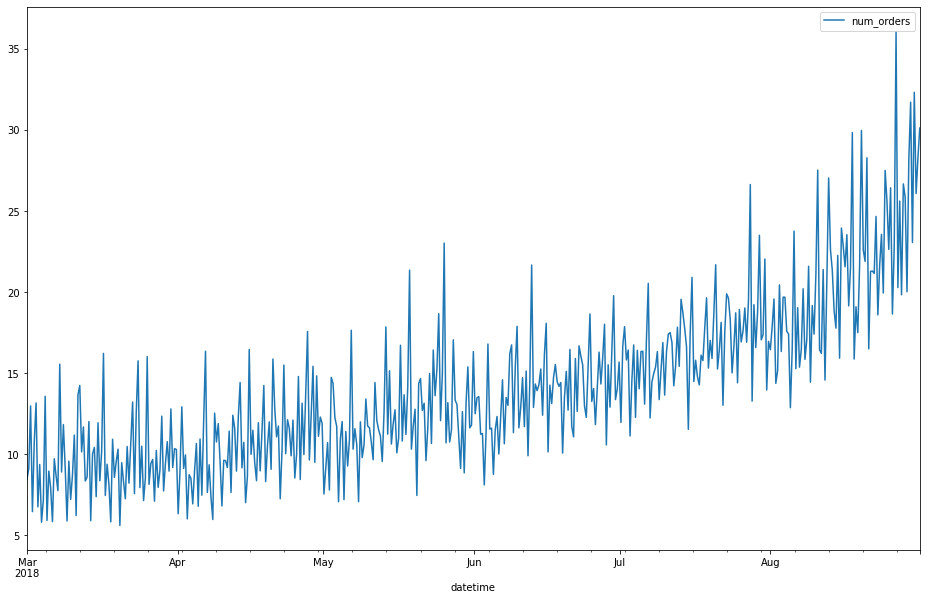

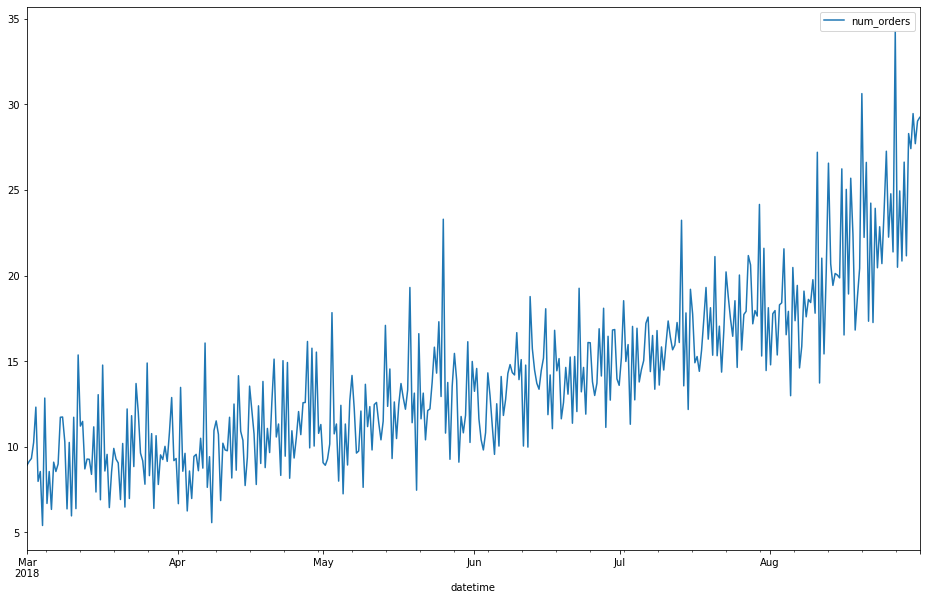

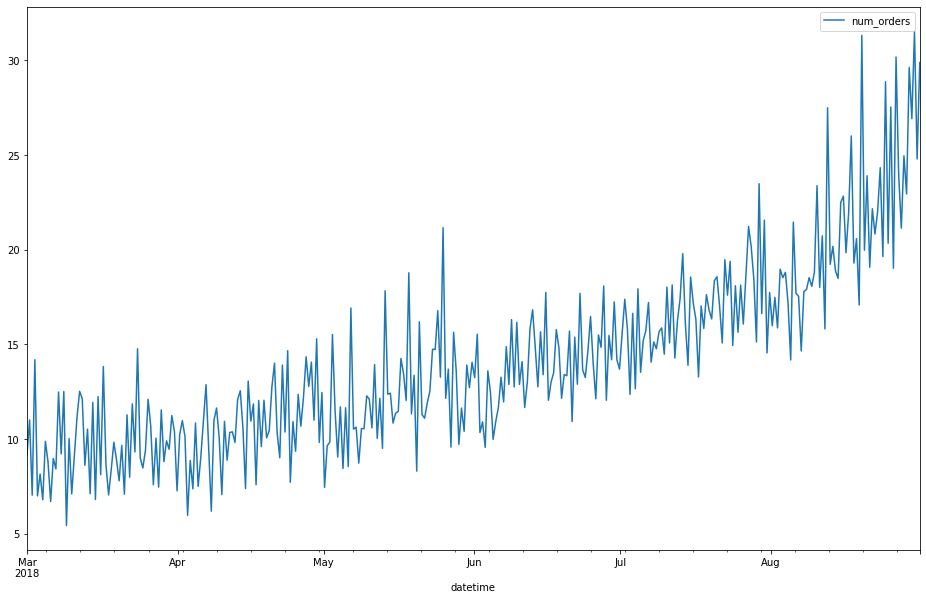

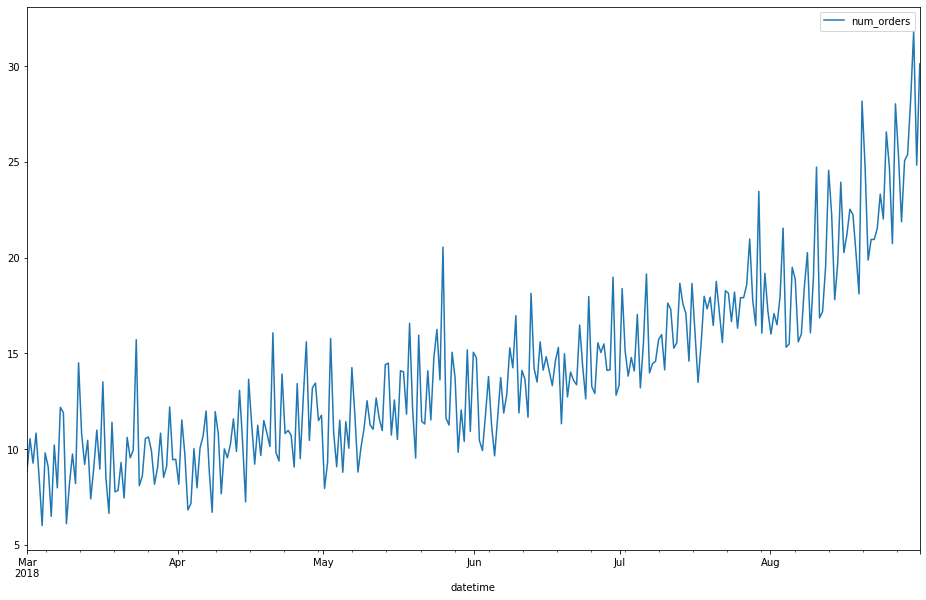

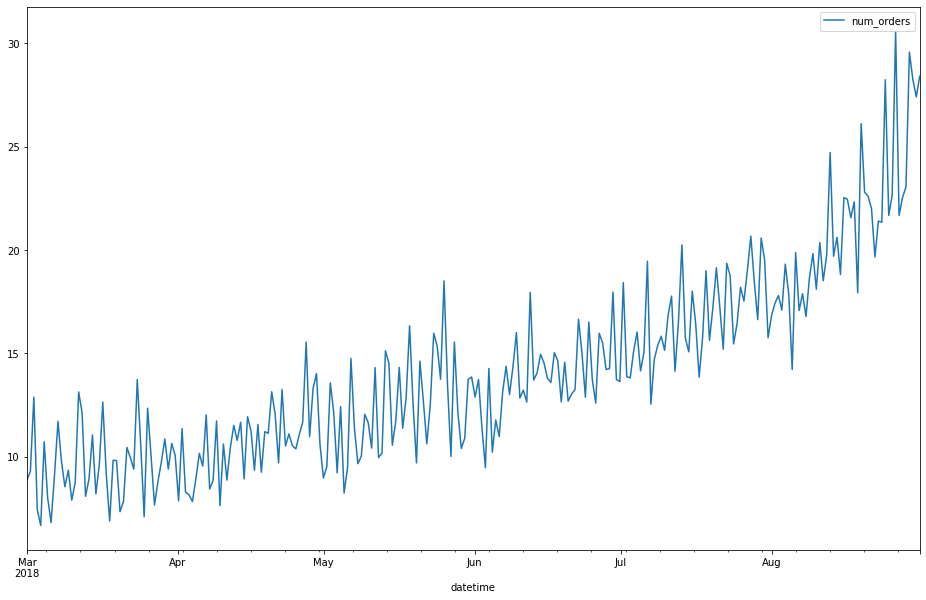

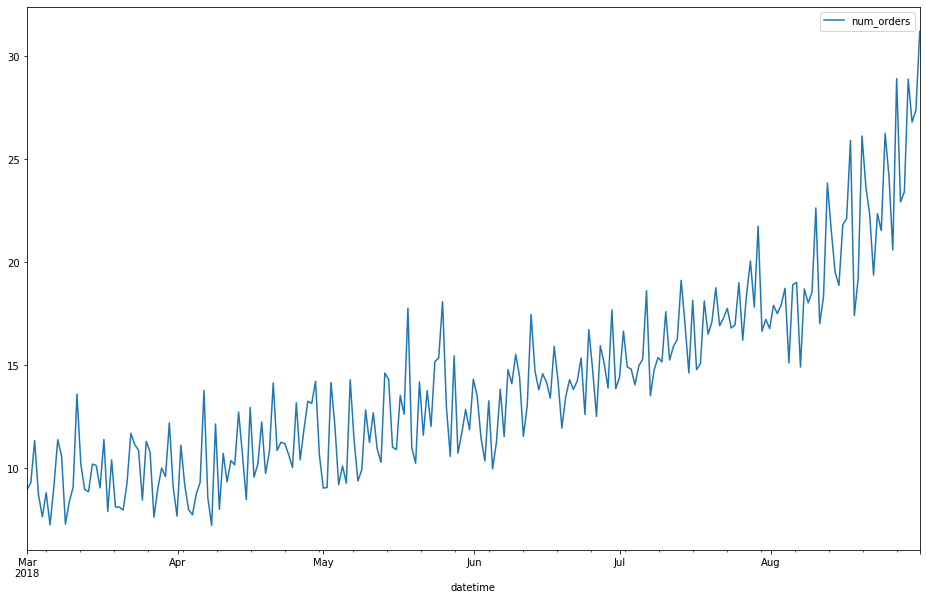

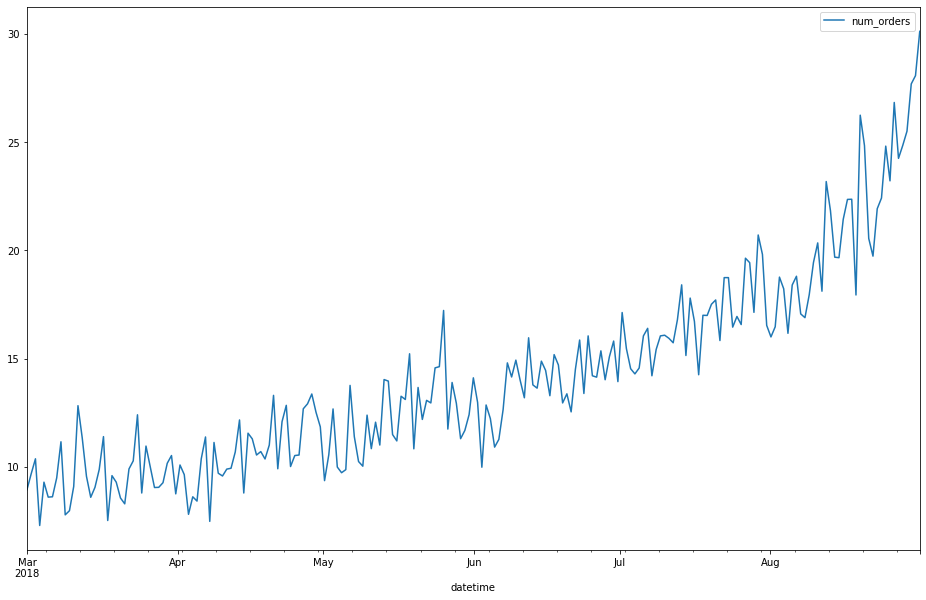

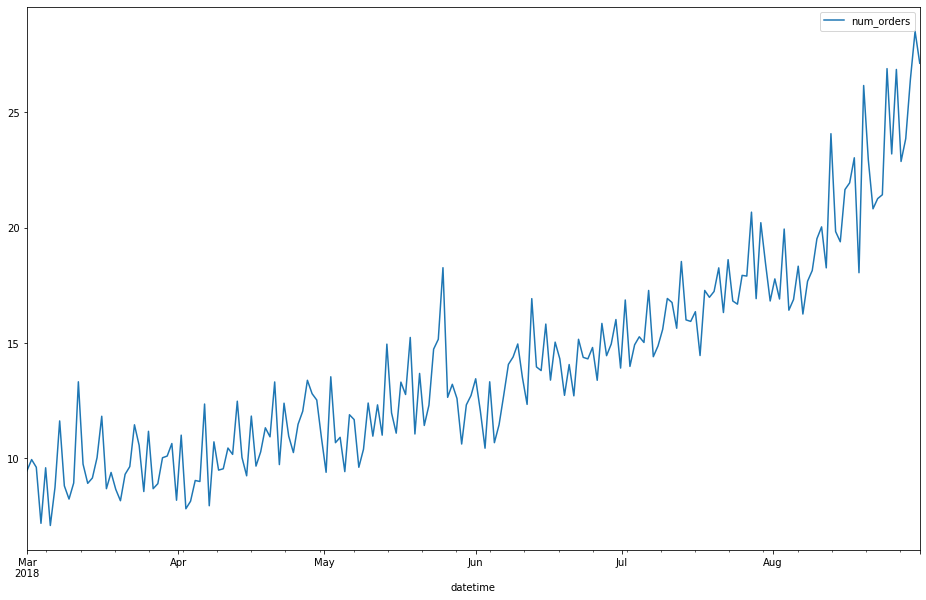

In [4]:
for i in range(1,24,2):
    data.resample(str(i)+'H').mean().plot(figsize=(16,10))


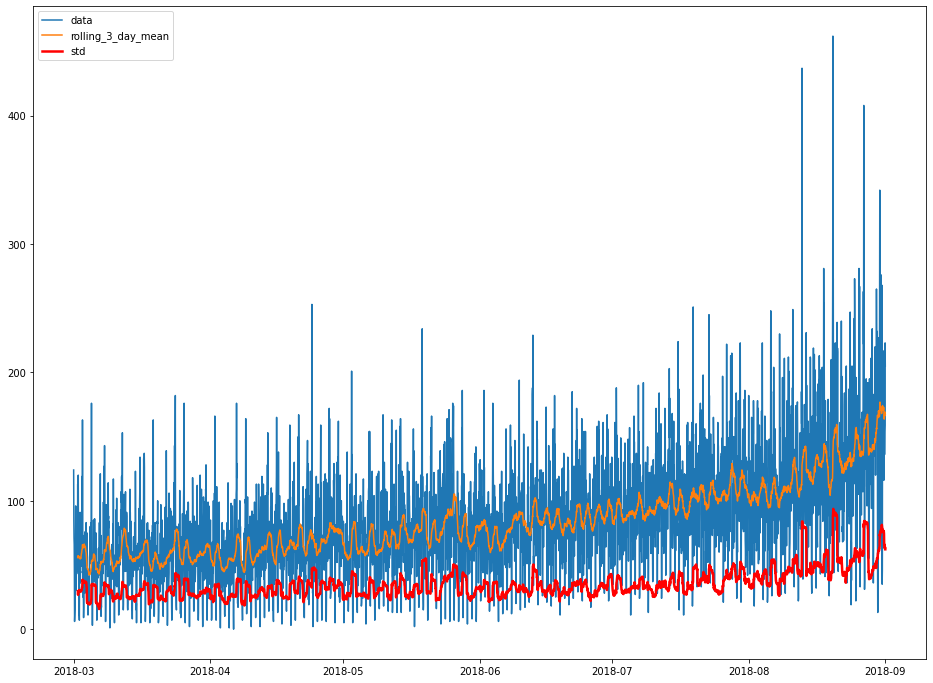

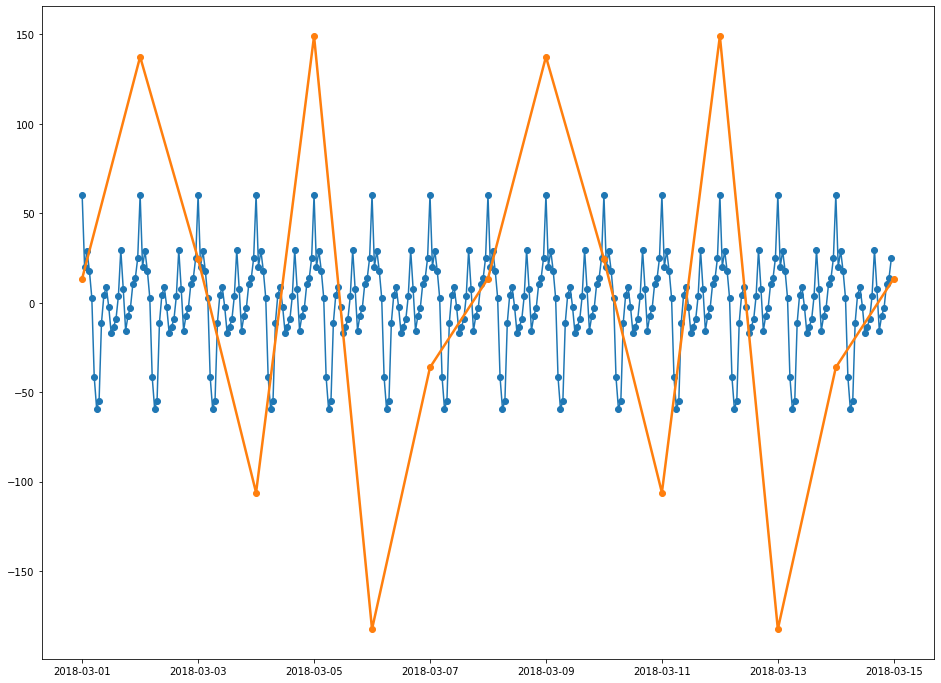

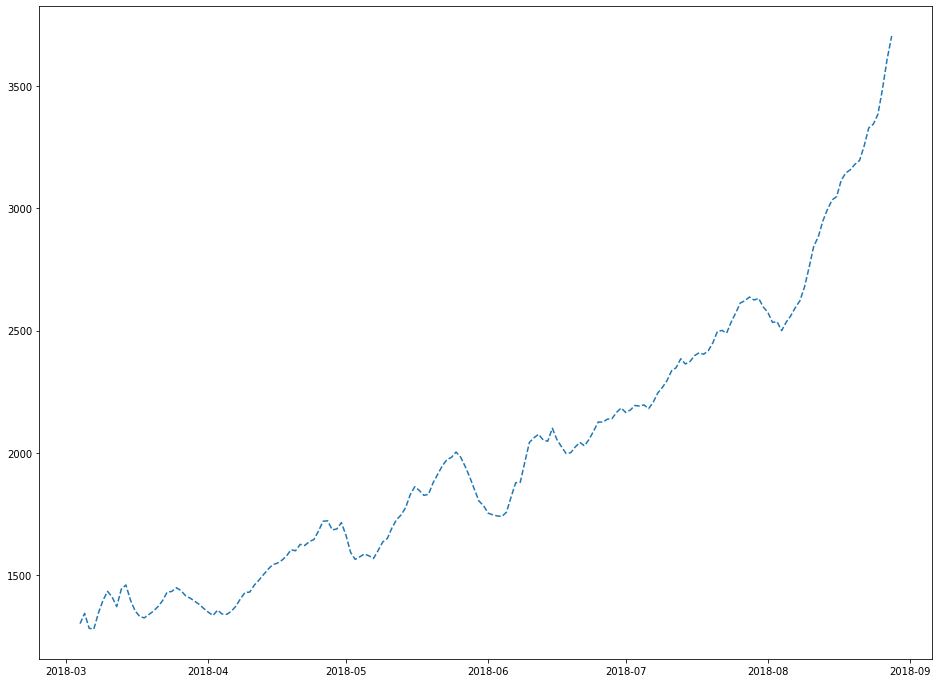

In [5]:
# Посмотрим на скользящее среднее и скользящее стандартное отклонение на 24 часа
data = data.resample('1H').sum()
plt.figure(figsize=(16,12))
plt.plot(data)
plt.plot(data.rolling(24).mean())
plt.plot(data.rolling(24).std(), lw=2.5, c='red')
plt.legend(['data', 'rolling_3_day_mean','std'])
plt.show()

#Выделим сезонность в рамках суток и в рамках недели
plt.figure(figsize=(16,12))
plt.plot(seasonal_decompose(data).seasonal.iloc[0:336],'-o')
plt.plot(seasonal_decompose(data.resample('1D').sum()).seasonal.iloc[0:15], '-o',  lw=2.5)
plt.show()

plt.figure(figsize=(16,12))
plt.plot(seasonal_decompose(data.resample('1D').sum()).trend,'--')
plt.show()

In [6]:
def features_gen(data, max_lag, rol_mean_size, plan_lag):
    data['month'] = data.index.month #добавим номер месяца
    data['day'] = data.index.day #добавим номер дня месяца
    data['dayofweek'] = data.index.dayofweek #добавим дня недели
    data['hour'] = data.index.hour #добавим номер часа
     #добавим сезонность почасовую со смещением на лаг планирования
    data['h_seasonal'] = seasonal_decompose(data['num_orders']).seasonal.shift(plan_lag)
    #добавим сезонность подневную со смещением на лаг планирования 
    data['d_seasonal'] = seasonal_decompose(data['num_orders'].resample('1D').mean()).seasonal
    data['d_seasonal'] = data['d_seasonal'].fillna(method='ffill').shift(plan_lag*6)
    #добавим тренд
    data['d_seasonal'] = seasonal_decompose(data['num_orders']).trend.shift(plan_lag)
    #добавим смещения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    #добавим скользящие
    for size in range(1, rol_mean_size + 1):
        data['rolling_mean_'+str(size)] = data['num_orders'].shift().rolling(size).mean()
    data = data.dropna(axis=0) #удаляем строки с пропусками в начале сета
    return data
    
data = features_gen(data, 10, 24, 24)
    
            

data.head()

,num_orders,month,day,dayofweek,hour,h_seasonal,d_seasonal,lag_1,lag_2,lag_3,...,rolling_mean_15,rolling_mean_16,rolling_mean_17,rolling_mean_18,rolling_mean_19,rolling_mean_20,rolling_mean_21,rolling_mean_22,rolling_mean_23,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 12:00:00,36,3,2,4,12,-16.721606,56.125000,91.0,54.0,45.0,...,58.066667,58.2500,57.470588,58.333333,57.578947,56.85,57.285714,56.863636,55.782609,54.708333
2018-03-02 13:00:00,45,3,2,4,13,-13.352412,56.145833,36.0,91.0,54.0,...,56.066667,56.6875,56.941176,56.277778,57.157895,56.50,55.857143,56.318182,55.956522,54.958333
2018-03-02 14:00:00,44,3,2,4,14,-9.191665,56.958333,45.0,36.0,91.0,...,51.533333,55.3750,56.000000,56.277778,55.684211,56.55,55.952381,55.363636,55.826087,55.500000
2018-03-02 15:00:00,59,3,2,4,15,3.731832,57.000000,44.0,45.0,36.0,...,50.600000,51.0625,54.705882,55.333333,55.631579,55.10,55.952381,55.409091,54.869565,55.333333
2018-03-02 16:00:00,82,3,2,4,16,29.604100,56.479167,59.0,44.0,45.0,...,48.533333,51.1250,51.529412,54.944444,55.526316,55.80,55.285714,56.090909,55.565217,55.041667


In [7]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

### Вывод

Посмотрев на данные, видно, что временной ряд нестационарный.
В качестве генерации признаков использовал номера часа, дня недели, дня месяца, месяца, добавил сезонность почасовую и подневную, тренд, сдвиги и скользящие

## Обучение

In [8]:
def rmse(target,preds):
    return mean_squared_error(target, preds, squared=False)
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Выделяем тестовый сет из обучающего набора данных
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, shuffle=False)


### LinearRegression

In [9]:
t0=time.perf_counter() # подсчет времени 

model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(X_train, y_train)

t1=time.perf_counter() # подсчет времени 

# Cоздаем предсказание и проверяем метрику
pred_tr = model_lr.predict(X_train)
result_tr = rmse(y_train, pred_tr)

pred_ts = model_lr.predict(X_test)
result_ts = rmse(y_test, pred_ts)

t2=time.perf_counter() # подсчет времени 
print('RMSE на обучающей выборке:', result_tr,'. RMSE на тестовой выборке:',result_ts)

RMSE на обучающей выборке: 23.002080434552987 . RMSE на тестовой выборке: 45.89141984777065


In [10]:
# Сбор данных по модели
timings=[]
timings.append(['linear_reg',(t1-t0),(t2-t1),(t2-t0),result_tr,result_ts])

### DecisionTreeRegressor

In [11]:
# Объявления общих данных для подбора параметров через Optuna
tscv = TimeSeriesSplit()
floatdist = optuna.distributions.LogUniformDistribution
intdist = optuna.distributions.IntUniformDistribution
catdist = optuna.distributions.CategoricalDistribution

In [12]:
# Параметры для подбора
params = {
    'max_depth' : intdist(1, 25),
    'min_samples_split' : intdist(2, 15),
    'min_samples_leaf' : intdist(2, 15)
}
# Объявляем модель
tree_model = DecisionTreeRegressor(random_state = STATE)
# Параметры для Орtuna
optuna_optimization = optuna.integration.OptunaSearchCV(
    tree_model, params, cv=tscv,
    n_trials=20, random_state=STATE,
    scoring='neg_root_mean_squared_error', refit=True)

t0=time.perf_counter() # подсчет времени
# подбор параметров
optuna_optimization.fit(X_train, y_train)
# модель с лучшими параметрами
best_tree_model = optuna_optimization.best_estimator_
print(optuna_optimization.best_params_)


/tmp/ipykernel_139/2357905840.py:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_optimization = optuna.integration.OptunaSearchCV(


{'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 15}


In [13]:
t1=time.perf_counter() # подсчет времени

# Cоздаем предсказание и проверяем метрику на трейновой выборке
pred_tr = best_tree_model.predict(X_train)
result_tr = rmse(y_train, pred_tr)
# Cоздаем предсказание и проверяем метрику на тестовой выборке
pred_ts = best_tree_model.predict(X_test)
result_ts = rmse(y_test, pred_ts)

t2=time.perf_counter() # подсчет времени
print('RMSE на обучающей выборке:', result_tr,'. RMSE на тестовой выборке:',result_ts)

#сбор данных
timings.append(['tree_reg',(t1-t0),(t2-t1),(t2-t0),result_tr,result_ts])

RMSE на обучающей выборке: 19.768145610026323 . RMSE на тестовой выборке: 43.697175283232504


### RandomForestRegressor

In [14]:
params = {
    'max_depth' : intdist(1, 25),
    'min_samples_split' : intdist(2, 15),
    'min_samples_leaf' : intdist(2, 15)
}

forest_model = RandomForestRegressor(random_state = STATE, n_jobs=-1)

optuna_optimization = optuna.integration.OptunaSearchCV(
    forest_model, params, cv=tscv,
    n_trials=20, random_state=STATE,
    scoring='neg_root_mean_squared_error', refit=True)

t0=time.perf_counter()

optuna_optimization.fit(X_train, y_train)

best_forest_model = optuna_optimization.best_estimator_
print(optuna_optimization.best_params_)


/tmp/ipykernel_139/38002206.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_optimization = optuna.integration.OptunaSearchCV(


{'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}


In [15]:
t1=time.perf_counter()

# Cоздаем предсказание и проверяем метрику
pred_tr = best_forest_model.predict(X_train)
result_tr = rmse(y_train, pred_tr)

pred_ts_b = best_forest_model.predict(X_test)
result_ts = rmse(y_test, pred_ts_b)

t2=time.perf_counter()
print(result_tr,result_ts)

timings.append(['forest_reg',(t1-t0),(t2-t1),(t2-t0),result_tr,result_ts])

13.082510744094131 40.121762410407165


### LightGBM

In [17]:
params = {
    'max_depth' : intdist(1, 25),
#    'learning_rate' : catdist([0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
    'num_leaves' : intdist(20, 100),
#    'reg_alpha' : floatdist(1e-3, 10.0),
#    'reg_lambda' : floatdist(1e-3, 10.0),
#    'subsample' : catdist([0.4,0.5,0.6,0.7,0.8,1.0]),
    
}


lgbm_model = lgb.LGBMRegressor(random_state = STATE,
                               metric='rmse',
                               n_estimators=50,
                               learning_rate=0.006,                       # Подобрано Optuna
                               reg_alpha=0.27727506763069126,             # Подобрано Optuna
                               reg_lambda=0.001229758913055063,           # Подобрано Optuna
                               subsample=0.8)                             # Подобрано Optuna


optuna_optimization = optuna.integration.OptunaSearchCV(
    lgbm_model, params, cv=tscv,
    n_trials=20, random_state=STATE,
    scoring='neg_root_mean_squared_error', refit=True)

t0=time.perf_counter()
optuna_optimization.fit(X_train, y_train)

best_lgbm_model = optuna_optimization.best_estimator_
print(optuna_optimization.best_params_)


C:\Users\Вадим и Света\AppData\Local\Temp\ipykernel_19292\1583007523.py:21: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_optimization = optuna.integration.OptunaSearchCV(


{'max_depth': 4, 'num_leaves': 100}


In [18]:
t1=time.perf_counter()

# Cоздаем предсказание и проверяем метрику
pred_tr = best_lgbm_model.predict(X_train)
result_tr = rmse(y_train, pred_tr)

pred_ts = best_lgbm_model.predict(X_test)
result_ts = rmse(y_test, pred_ts)

t2=time.perf_counter()
print(result_tr,result_ts,)

timings.append(['lgbm_reg',(t1-t0),(t2-t1),(t2-t0),result_tr,result_ts])

19.109764270285865 39.91621635173646


In [19]:
timings = (pd.DataFrame(np.array(timings),
                       columns=['model','params_optimization', 'prediction', 'all_time', 'rmse_training_sample', 'rmse_test_sample'])
           .set_index('model',drop=True))

In [20]:
timings

,params_optimization,prediction,all_time,rmse_training_sample,rmse_test_sample
model,,,,,
linear_reg,0.006311399999999523,0.004018800000000766,0.01033020000000029,23.002080434552987,45.891419847770756
tree_reg,3.480150600000001,0.004763599999998647,3.4849141999999995,19.768145610026323,43.697175283232504
forest_reg,30.3276962,0.03925840000000136,30.3669546,13.08251074409413,40.121762410407165
lgbm_reg,84.9892935,0.036524399999990464,85.02581789999999,19.109764270285865,39.91621635173646


### Вывод

## Анализ результатов

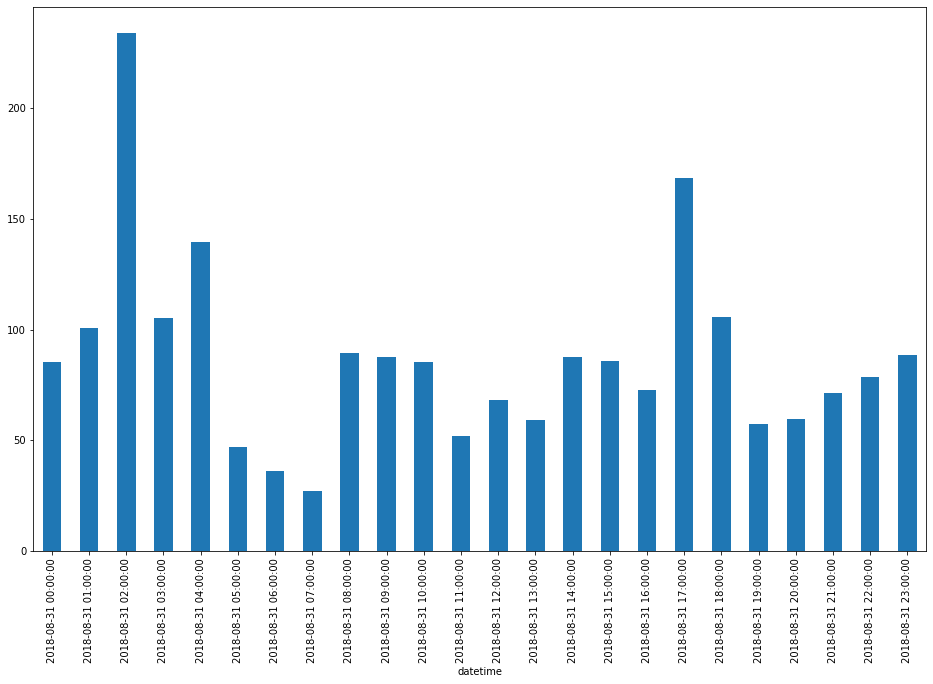

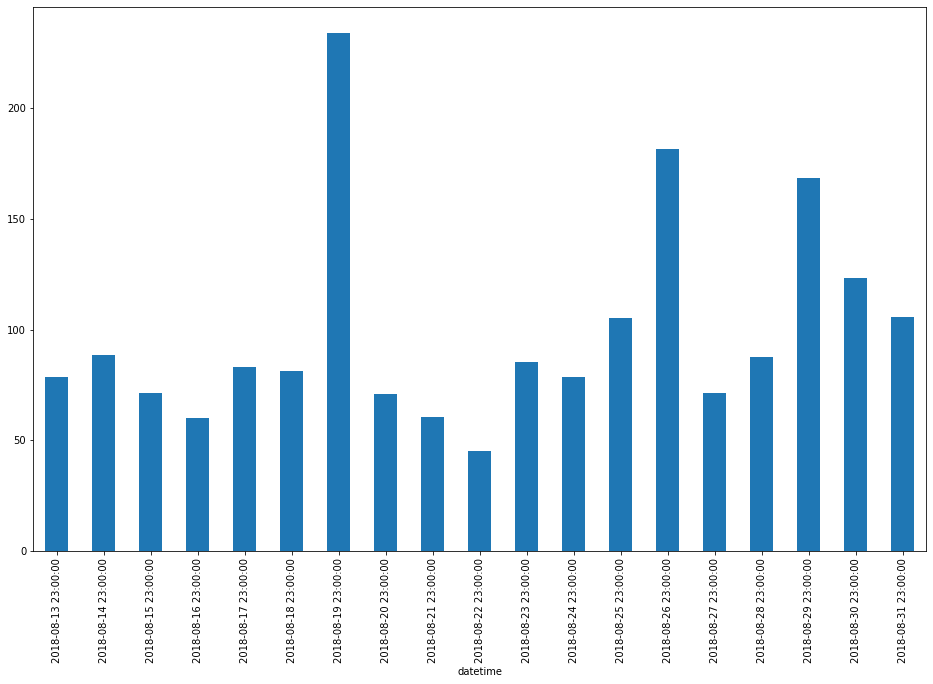

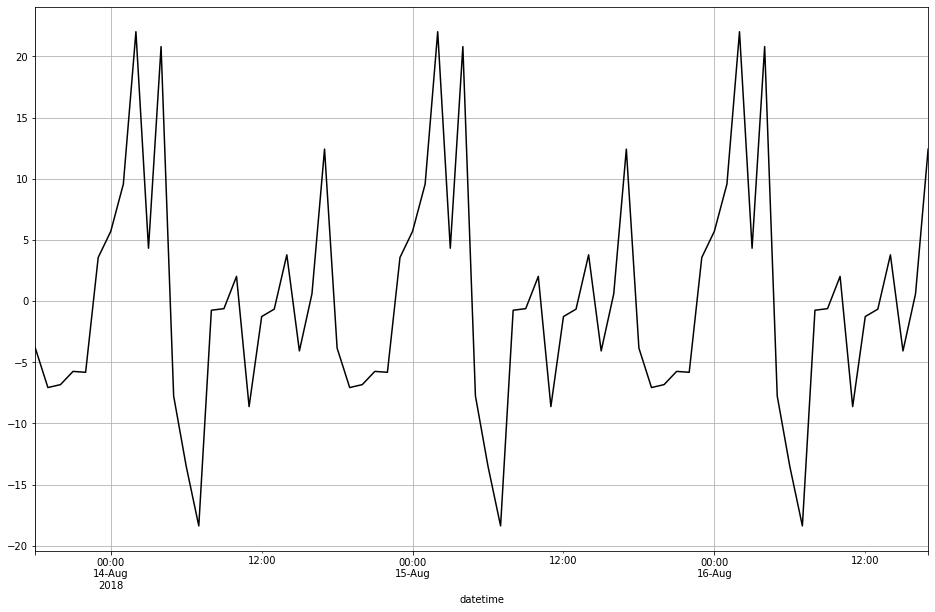

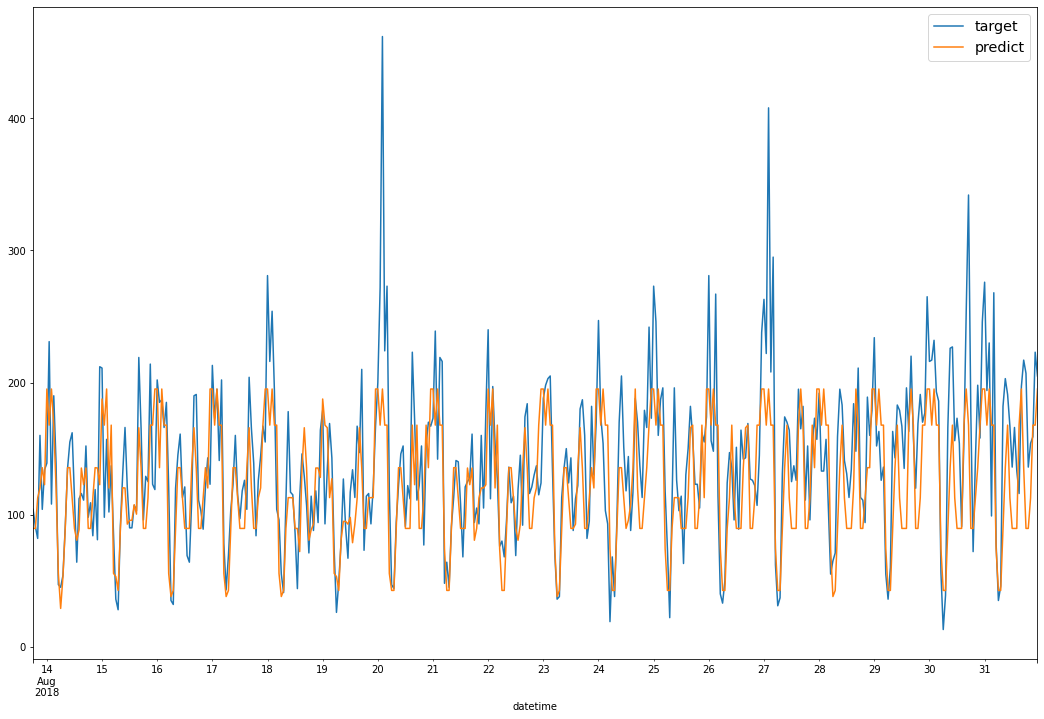

In [21]:
residue = pd.Series(abs(pd.Series(pred_ts_b) - y_test.reset_index(drop=True)),name='error')
y_testy=y_test.reset_index().join([residue, pd.Series(pred_ts, name='predict')])
y_testy = y_testy.set_index('datetime', drop=True)

y_testy['error'].groupby(y_testy.index.day).plot(kind='bar',figsize=(16,10))
plt.show()
y_testy['error'].groupby(y_testy.index.hour).plot(kind='bar',figsize=(16,10))
plt.show()
seasonal_decompose(y_testy['error']).seasonal.iloc[0:72].plot(style='-0', figsize=(16,10), grid=True)
plt.show()

plt.figure(figsize=(18,12))
y_testy['num_orders'].plot()
y_testy['predict'].plot()
plt.legend(['target', 'predict'], fontsize='x-large')
plt.show()

### Вывод
Из проверенных моделей оптимальная по точности предсказания и времени обучения является модель RandomForestRegressor, анализ остатков показывает, что модель RandomForestRegressor дает наибольшие отклонения в ночные часы с 23-00 до 4-00, и в воскресенье по дням недели, в почасовых отклонениях есть сезонность, а значит можно увеличить точность модели поработав над признаками и параметрами модели.
    Необходимую точность предсказаний RMSE < 48.0 достигнута, на выбранной модели на тестовой выборке RMSE = 40.12